# Purpose


This notebook demonstrates the data pipeline from raw tables to analytical datasets. At the end of this activity, train & test data sets are created from raw data.



## Imports

In [30]:
from pprint import pprint
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.options.mode.use_inf_as_na = True


In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, get_package_path,
    display_as_tabs, string_cleaning, merge_info, initialize_environment,
    list_datasets, load_dataset, save_dataset
)
import ta_lib.eda.api as eda

In [33]:
initialize_environment(debug=False, hide_warnings=True)

## Utility functions

# 1. Initialization

In [34]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
pprint(list_datasets(context))

google_df = load_dataset(context, 'raw/google')
product_df = load_dataset(context, 'raw/product')
sales_df = load_dataset(context, 'raw/sales')
media_df = load_dataset(context, 'raw/media')
theme_list_df = load_dataset(context, 'raw/theme_list')
tpl_df = load_dataset(context, 'raw/tpl')

['/raw/google',
 '/raw/product',
 '/raw/sales',
 '/raw/media',
 '/raw/theme_list',
 '/raw/tpl',
 '/cleaned/google',
 '/cleaned/product',
 '/cleaned/sales',
 '/cleaned/media',
 '/cleaned/theme_list',
 '/cleaned/tpl',
 '/processed/sales',
 '/train/sales/features',
 '/train/sales/target',
 '/test/sales/features',
 '/test/sales/target',
 '/score/sales/output']


# 2. Data cleaning and consolidation

**<u>NOTES</u>**

The focus here is to create a cleaned dataset that is appropriate for solving the DS problem at hand from the raw data.

**1. Do**
* clean dataframe column names
* ensure dtypes are set properly
* join with other tables etc to create features
* transform, if appropriate, datetime like columns to generate additional features (weekday etc)
* transform, if appropriate, string columns to generate additional features
* discard cols that are not useful for training the model (IDs, constant cols, duplicate cols etc)
* additional features generated from existing columns


**2. Don't**
* handle missing values or outliers here. mark them and leave them for processing downstream.


## 2.1 Clean individual tables 

### Google Table

From data discovery, we know the following

* One column is strings : nothing to fix. Apply generic cleaning (strip extra whitespace etc)
* This will go into production code


In [35]:
str_cols = list(
    set(google_df.select_dtypes('object').columns.to_list())
    - set(['date'])
)

google_df_clean = (
    google_df
    # while iterating on testing, it's good to copy the dataset(or a subset)
    # as the following steps will mutate the input dataframe. The copy should be
    # removed in the production code to avoid introducing perf. bottlenecks.
    .copy()

    # set dtypes : nothing to do here
    .passthrough()

    .to_datetime('date', format='%d-%m-%Y')

    .transform_columns(str_cols, string_cleaning, elementwise=False)
    
    # .replace({'': np.NaN})
    
    # drop unnecessary cols : nothing to do here
    
    # ensure that the key column does not have duplicate records
    # .remove_duplicate_rows(col_names=['PRODUCT_ID'], keep_first=True)
    
    # clean column names (comment out this line while cleaning data above)
    .clean_names(case_type='snake')
)
google_df_clean.head()

,date,platform,search_volume,claim_id,week_number,year_new
0,2014-01-05,google,349,916,1,2014
1,2014-01-06,google,349,916,2,2014
2,2014-01-07,google,697,916,2,2014
3,2014-01-10,google,349,916,2,2014
4,2014-01-20,google,697,916,4,2014


### Products Table

From data discovery, we know the following

* One column is strings : nothing to fix. Apply generic cleaning (strip extra whitespace etc)
* PRODUCT_ID is key column : ensure no duplicate values
* This will go into production code


In [36]:
str_cols = list(
    set(product_df.select_dtypes('object').columns.to_list())
)

product_df_clean = (
    product_df
    # while iterating on testing, it's good to copy the dataset(or a subset)
    # as the following steps will mutate the input dataframe. The copy should be
    # removed in the production code to avoid introducing perf. bottlenecks.
    .copy()

    # set dtypes : nothing to do here
    .passthrough()

    .transform_columns(str_cols, string_cleaning, elementwise=False)
    
    # .replace({'': np.NaN})
    
    # drop unnecessary cols : nothing to do here
    
    # ensure that the key column does not have duplicate records
    .remove_duplicate_rows(col_names=['PRODUCT_ID'], keep_first=True)
    
    # clean column names (comment out this line while cleaning data above)
    .clean_names(case_type='snake')
)
product_df_clean.head()

,product_id,vendor
0,1,Others
1,2,Others
2,3,Others
3,4,Others
4,5,Others


### Sales Table

From data discovery, we know the following

* No column is strings : nothing to fix.
* Change system_calendar_key_N column to datetime
* This will go into production code


In [37]:
sales_df['system_calendar_key_N'] = sales_df['system_calendar_key_N'].apply(str)
sales_df_clean = (
    sales_df
    # while iterating on testing, it's good to copy the dataset(or a subset)
    # as the following steps will mutate the input dataframe. The copy should be
    # removed in the production code to avoid introducing perf. bottlenecks.
    .copy()

    # set dtypes : nothing to do here
    .passthrough()

    .to_datetime('system_calendar_key_N', format='%Y%m%d')

    # .transform_columns(str_cols, string_cleaning, elementwise=False)
    
    # .replace({'': np.NaN})
    
    # drop unnecessary cols : nothing to do here
    
    # ensure that the key column does not have duplicate records
    # .remove_duplicate_rows(col_names=['PRODUCT_ID'], keep_first=True)
    
    # clean column names (comment out this line while cleaning data above)
    .clean_names(case_type='snake')
)
sales_df_clean.head()

,system_calendar_key_n,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
0,2016-01-09,1,13927.0,934,18680
1,2016-01-09,3,10289.0,1592,28646
2,2016-01-09,4,357.0,22,440
3,2016-01-09,6,23113.0,2027,81088
4,2016-01-09,7,23177.0,3231,58164


### Media Table

From data discovery, we know the following

* Change published_date column to datetime
* This will go into production code


In [38]:
media_df['published_date'] = media_df['published_date'].apply(lambda x: x.replace('/','-'))
media_df_clean = (
    media_df
    # while iterating on testing, it's good to copy the dataset(or a subset)
    # as the following steps will mutate the input dataframe. The copy should be
    # removed in the production code to avoid introducing perf. bottlenecks.
    .copy()

    # set dtypes : nothing to do here
    .passthrough()

    .to_datetime('published_date', format='%m-%d-%Y')

    # .transform_columns(str_cols, string_cleaning, elementwise=False)
    
    # .replace({'': np.NaN})
    
    # drop unnecessary cols : nothing to do here
    
    # ensure that the key column does not have duplicate records
    # .remove_duplicate_rows(col_names=['PRODUCT_ID'], keep_first=True)
    
    # clean column names (comment out this line while cleaning data above)
    .clean_names(case_type='snake')
)
media_df_clean.head()

,theme_id,published_date,total_post
0,148.0,2015-10-01,76
1,148.0,2015-10-10,31
2,148.0,2015-10-11,65
3,148.0,2015-10-12,88
4,148.0,2015-10-13,85


### Theme List Table

From data discovery, we know the following

* One column is string : nothing to fix. Apply generic cleaning (strip extra whitespace etc)
* This will go into production code


In [39]:
str_cols = list(
    set(theme_list_df.select_dtypes('object').columns.to_list())
)
theme_list_df_clean = (
    theme_list_df
    # while iterating on testing, it's good to copy the dataset(or a subset)
    # as the following steps will mutate the input dataframe. The copy should be
    # removed in the production code to avoid introducing perf. bottlenecks.
    .copy()

    # set dtypes : nothing to do here
    .passthrough()

    # .transform_columns(str_cols, string_cleaning, elementwise=False)
    
    # .replace({'': np.NaN})
    
    # drop unnecessary cols : nothing to do here
    
    # ensure that the key column does not have duplicate records
    # .remove_duplicate_rows(col_names=['PRODUCT_ID'], keep_first=True)
    
    # clean column names (comment out this line while cleaning data above)
    .clean_names(case_type='snake')
)
theme_list_df_clean.head()

,claim_id,claim_name
0,0,No Claim
1,8,low carb
2,15,beans
3,16,cocoa
4,26,vanilla


### Theme Production List Table

From data discovery, we know the following

* No column is string : nothing to fix. 
* This will go into production code


In [40]:
tpl_df_clean = (
    tpl_df
    # while iterating on testing, it's good to copy the dataset(or a subset)
    # as the following steps will mutate the input dataframe. The copy should be
    # removed in the production code to avoid introducing perf. bottlenecks.
    .copy()

    # set dtypes : nothing to do here
    .passthrough()

    # .transform_columns(str_cols, string_cleaning, elementwise=False)
    
    # .replace({'': np.NaN})
    
    # drop unnecessary cols : nothing to do here
    
    # ensure that the key column does not have duplicate records
    # .remove_duplicate_rows(col_names=['PRODUCT_ID'], keep_first=True)
    
    # clean column names (comment out this line while cleaning data above)
    .clean_names(case_type='snake')
)
tpl_df_clean.head()

,product_id,claim_id
0,26,8
1,29,8
2,48,81
3,50,81
4,74,227


### NOTE

It's always a good idea to save cleaned tabular data using a storage format that supports the following 

1. preserves the type information
2. language agnostic storage format
3. Supports compression
4. Supports customizing storage to optimize different data access patterns

For larger datasets, the last two points become crucial.

`Parquet` is one such file format that is very popular for storing tabular data. It has some nice properties:
- Similar to pickles & RDS datasets, but compatible with all languages
- Preserves the datatypes
- Compresses the data and reduces the filesize
- Good library support in Python and other languages
- As a columnar storage we can efficiently read fewer columns
- It also supports chunking data by groups of columns (for instance, by dates or a particular value of a key column) that makes loading subsets of the data fast.

In [41]:
save_dataset(context, google_df_clean, 'cleaned/google')
save_dataset(context, product_df_clean, 'cleaned/product')
save_dataset(context, sales_df_clean, 'cleaned/sales')
save_dataset(context, media_df_clean, 'cleaned/media')
save_dataset(context, theme_list_df_clean, 'cleaned/theme_list')
save_dataset(context, tpl_df_clean, 'cleaned/tpl')

## 2.2 Create consolidated features table

Here we take the cleaned dataframes and merge them to form the consolidated table.

We know from data discovery that `products` is a dimension table and `orders` is a fact table, so we want to do a left join here. * This will go into production code

### List of themes available across all data sources

In [42]:
lists = theme_list_df_clean.claim_name.unique().tolist()
print(len(lists))
print(lists)

208
['No Claim', 'low carb', 'beans', 'cocoa', 'vanilla', 'stroganoff', 'cumin', 'high/source of protein', 'no additives/preservatives', 'buckwheat', 'tutti frutti', 'ethical - not specific', 'brown ale', 'french bisque', 'pheasant', 'whitebait', 'gmo free', 'low calorie', 'peach', 'crab', 'nuts', 'venison', 'fruit', 'convenience - easy-to-prepare', 'anchovy', 'pomegranate', 'scallop', 'american gumbo', 'tuna', 'low sodium', 'low sugar', 'french', 'chicken', 'ethical - packaging', 'cherry', 'vitamin/mineral fortified', 'liver', 'red raspberry', 'cookie', 'pollock', 'blueberry', 'bone health', 'prebiotic', 'poultry', 'cheddar cheese', 'energy/alertness', 'halal', 'herbs', 'pizza', 'american southwest style', 'salmon', 'beef hamburger', 'tilapia', 'mackerel', 'peanut', 'lobster', 'sea salt', 'soy foods', 'apple cinnamon', 'gingerbread', 'vegetarian', 'ethnic & exotic', 'cream', 'berry', 'gluten free', 'added calcium', 'added fiber', 'added iron', 'added protein', 'allergy', 'anti-aging/a

### Understand the overall market share of A

In [43]:
fs_df = pd.merge(sales_df_clean, product_df_clean, on='product_id', how= 'inner')
merge_info(sales_df_clean,product_df_clean, fs_df)

,n_cols,n_rows
left_df,5,4526182
right_df,2,67175
merged_df,6,4526182


In [44]:
fs_df.duplicated().sum()

0

In [45]:
market_share = fs_df.groupby('vendor')['sales_dollars_value'].sum().to_frame()
market_share = market_share*100/market_share.sum()
market_share.reset_index(inplace=True)
market_share.rename(columns = {'sales_dollars_value':'market_share_in_%'}, inplace = True)
market_share

,vendor,market_share_in_%
0,A,31.647006
1,B,15.736254
2,D,12.243428
3,E,1.984087
4,F,5.111352
5,G,1.996254
6,H,2.330302
7,Others,18.972815
8,Private Label,9.978502


### The potential competitors for A in each theme

In [46]:
theme_df = pd.merge(theme_list_df_clean, tpl_df_clean, on='claim_id', how= 'inner')
merge_info(theme_list_df_clean,tpl_df_clean, theme_df)

,n_cols,n_rows
left_df,2,208
right_df,2,91485
merged_df,3,91485


In [47]:
theme_df.claim_id.nunique()

51

In [48]:
final_sales_df = pd.merge(fs_df, theme_df, on='product_id', how= 'inner')
merge_info(fs_df,theme_df, final_sales_df)

,n_cols,n_rows
left_df,6,4526182
right_df,3,91485
merged_df,8,7767420


In [49]:
set(theme_df.claim_id.unique()) - set(final_sales_df.claim_id.unique())

{59, 157}

In [50]:
theme_df[(theme_df.claim_id == 59) | (theme_df.claim_id == 157)]

,claim_id,claim_name,product_id
62139,59,tutti frutti,5800
62140,59,tutti frutti,5822
62141,59,tutti frutti,5801
62142,59,tutti frutti,5816
62143,59,tutti frutti,5795
62144,59,tutti frutti,5797
62145,59,tutti frutti,5818
62146,59,tutti frutti,5760
62147,59,tutti frutti,5761
62148,59,tutti frutti,5763


In [51]:
potential_competitor = final_sales_df.groupby(['claim_name', 'vendor'])['sales_dollars_value'].sum().reset_index()
potential_competitor.sort_values(by= ['claim_name','sales_dollars_value'], ascending=[True,False],inplace=True)

In [52]:
potential_competitor = potential_competitor.groupby(['claim_name']).head(5)

In [53]:
sum1 = eda.get_variable_summary(potential_competitor)
display_as_tabs([('competitor', sum1)])

Tabs
    [0] DataFrame(name='competitor', value=                          ...)

In [54]:
potential_competitor.vendor.value_counts()

Others           46
A                32
B                22
Private Label    20
F                17
D                16
H                 9
Name: vendor, dtype: int64

In [55]:
import matplotlib.pyplot as plt

In [56]:
potential_competitor[potential_competitor.claim_name == 'beans']

,claim_name,vendor,sales_dollars_value
31,beans,Others,302386662.0
30,beans,D,2721468.0
29,beans,A,965413.0
32,beans,Private Label,294874.0


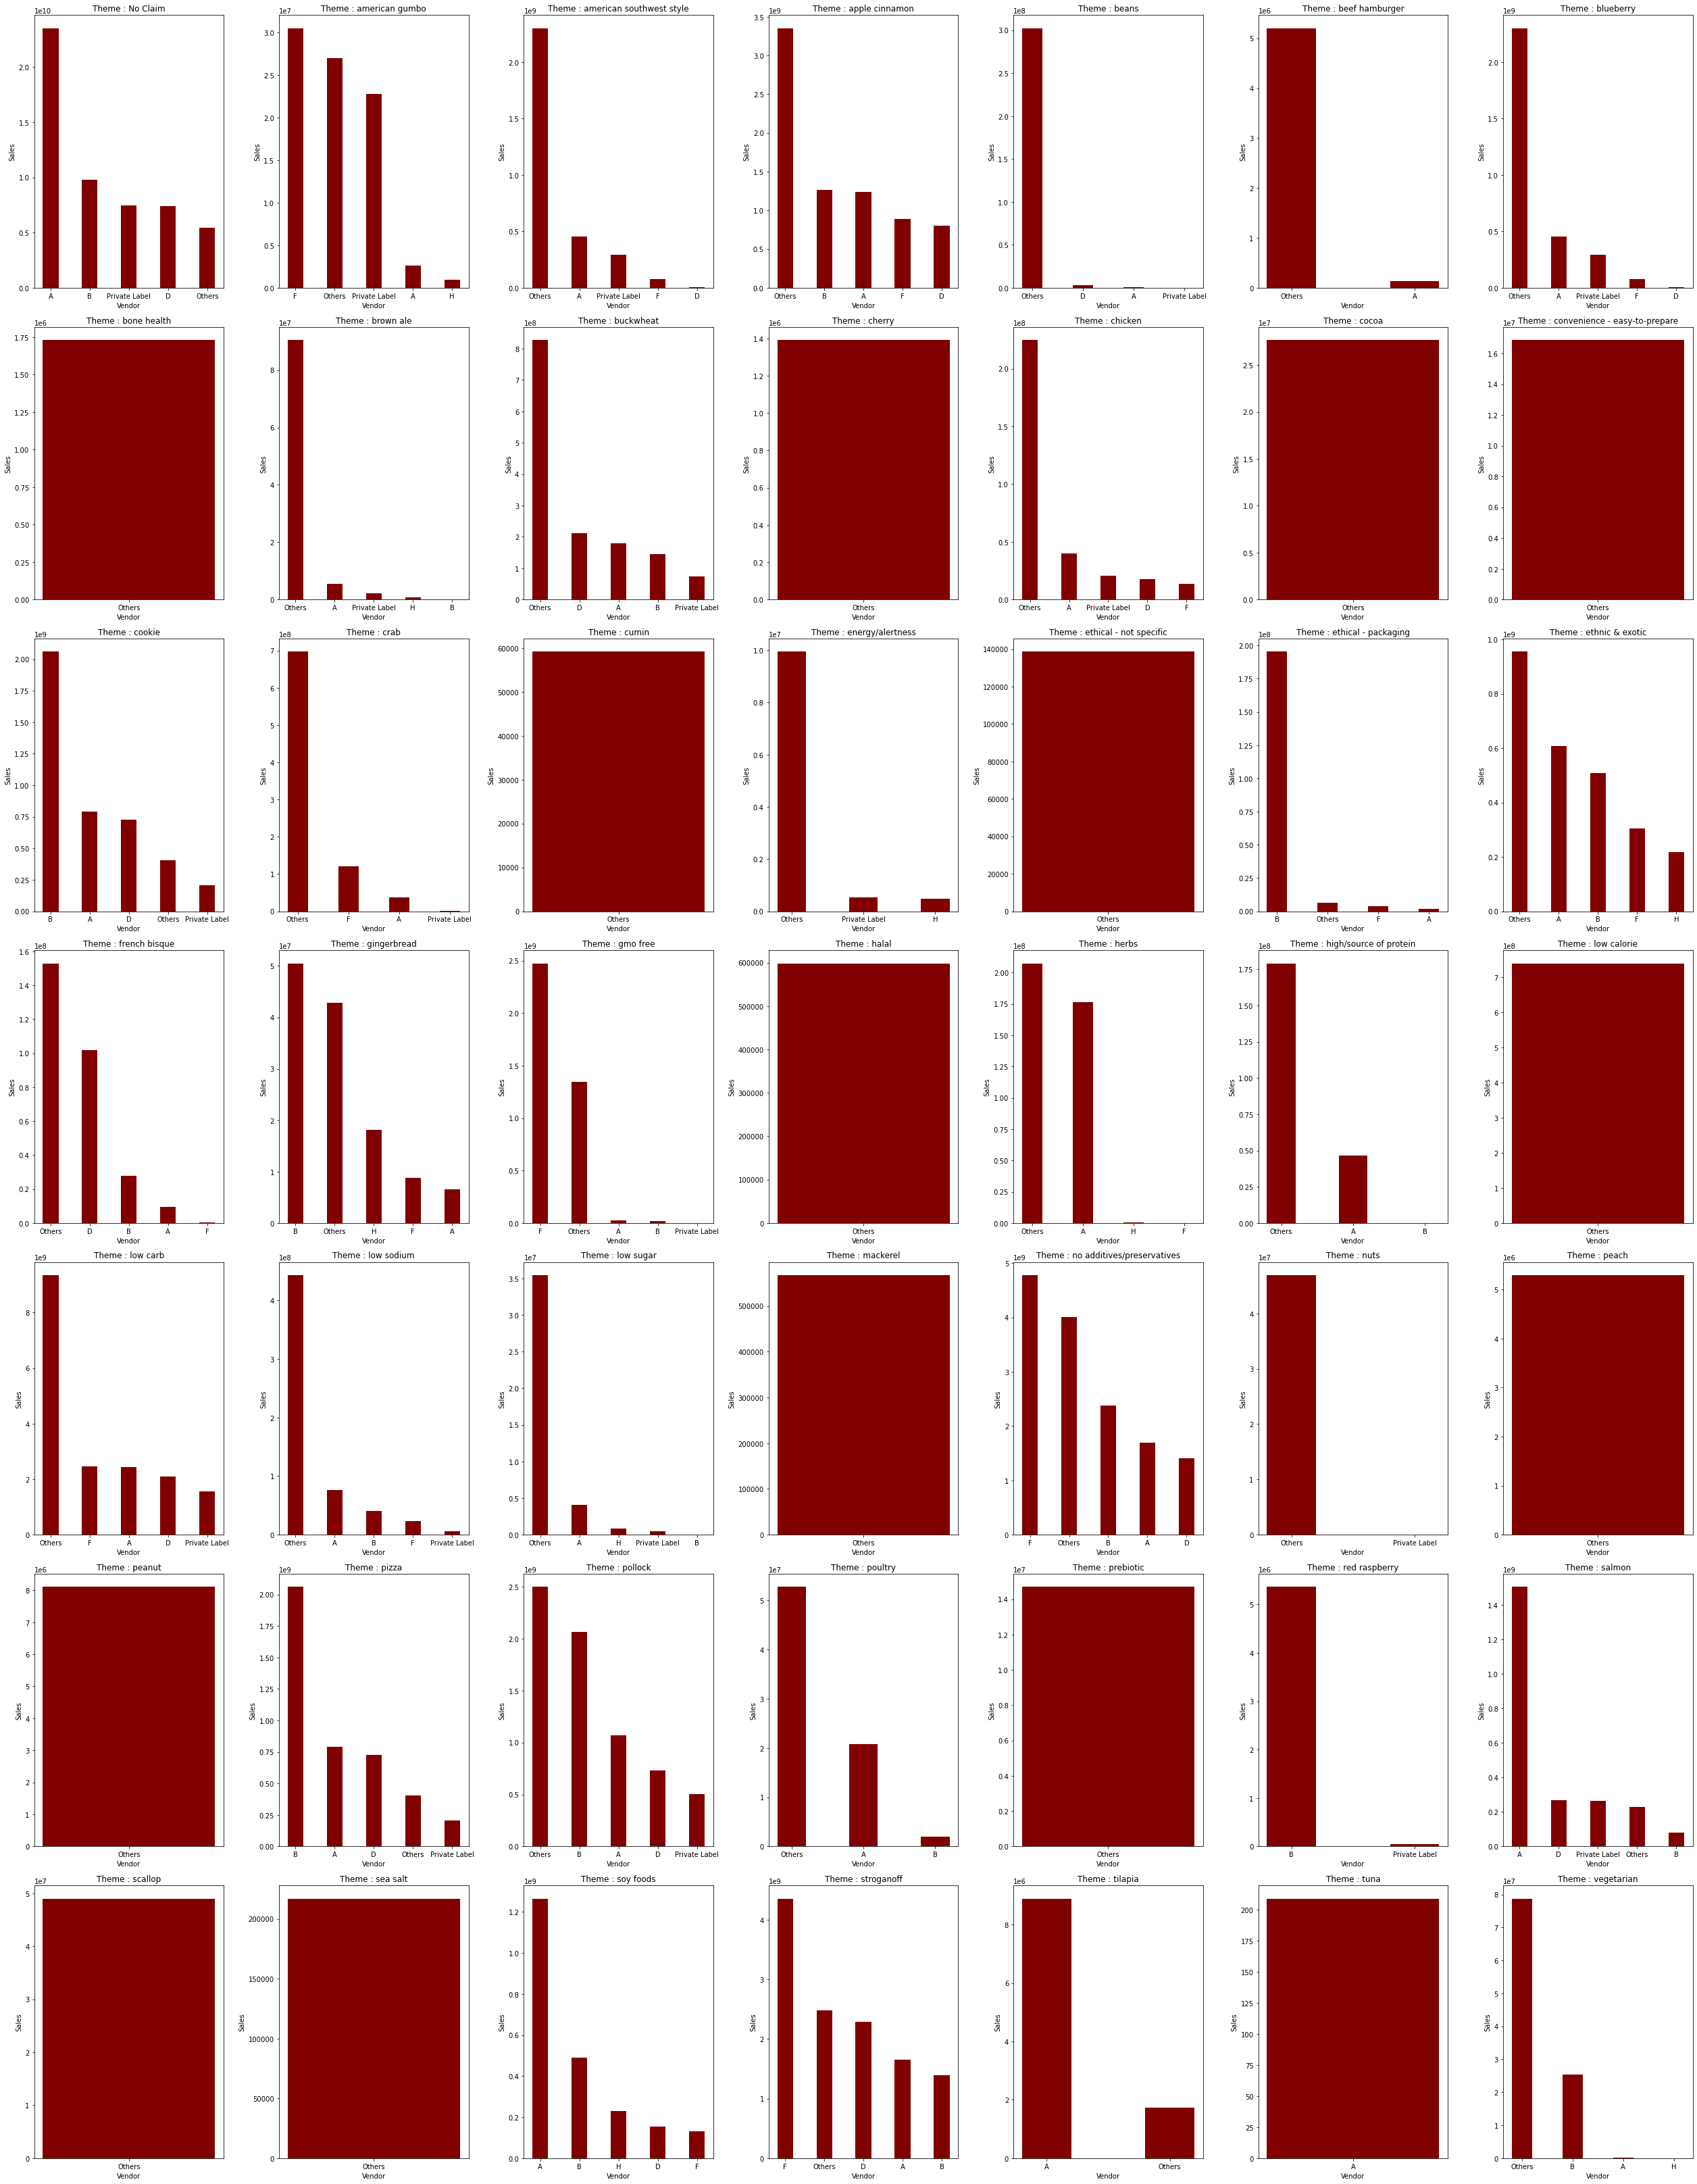

In [57]:
themes = potential_competitor.claim_name.unique().tolist()
fig, axs = plt.subplots(7, 7,figsize=(35,45))
for j,i in enumerate(themes):
    # potential_competitor[potential_competitor.claim_name == i].unstack().plot(kind='bar', figsize = (15,10))
    d = potential_competitor[potential_competitor.claim_name == i]
 
    # creating the bar plot
    m = j//7
    n = j%7
    axs[m,n].bar(d.vendor, d.sales_dollars_value, color ='maroon',
            width = 0.4)
    
#     axs[m,n].xlabel("Vendor")
#     axs[m,n].ylabel("Sales")
    axs[m,n].set_title("Theme : {}".format(i))
#     axs[m,n].show()

for ax in axs.flat:
    ax.set(xlabel='Vendor', ylabel='Sales')

### Understands consumer preference(themes)

In [59]:
counsumer_preference = final_sales_df.groupby('claim_name')['sales_dollars_value'].count().to_frame()
counsumer_preference.sort_values(by= ['sales_dollars_value'], ascending=[False],inplace=True)
counsumer_preference.reset_index()

,claim_name,sales_dollars_value
0,No Claim,2045703
1,low carb,1668808
2,no additives/preservatives,826406
3,apple cinnamon,520679
4,stroganoff,387999
5,pollock,338116
6,blueberry,218897
7,american southwest style,218897
8,gmo free,215635
9,buckwheat,175912


In [58]:
counsumer_preference = final_sales_df.groupby('claim_name')['sales_dollars_value'].sum().to_frame()
counsumer_preference.sort_values(by= ['sales_dollars_value'], ascending=[False],inplace=True)
counsumer_preference.reset_index()

,claim_name,sales_dollars_value
0,No Claim,5.876714e+10
1,low carb,1.862566e+10
2,no additives/preservatives,1.438821e+10
3,stroganoff,1.275780e+10
4,apple cinnamon,8.094533e+09
5,pollock,7.007307e+09
6,cookie,4.254113e+09
7,pizza,4.254113e+09
8,gmo free,3.859459e+09
9,american southwest style,3.137485e+09


### Validate the hypothesis: Trend flows from Social -> Search -> Sales

In [80]:
media_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533390 entries, 0 to 533389
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   claim_id    314879 non-null  float64       
 1   date        533390 non-null  datetime64[ns]
 2   total_post  533390 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.3 MB


In [79]:
# media_df_clean['theme_id'] = media_df_clean['theme_id'].astype(Int64)
media_df_clean = media_df_clean.rename(columns = {'published_date': 'date', 'theme_id': 'claim_id'})

In [67]:
google_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181565 entries, 0 to 181564
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           181565 non-null  datetime64[ns]
 1   platform       181565 non-null  object        
 2   search_volume  181565 non-null  int64         
 3   claim_id       181565 non-null  float64       
 4   week_number    181565 non-null  int64         
 5   year_new       181565 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 8.3+ MB


In [87]:
# hyp_df = pd.merge(google_df_clean,media_df_clean, left_on=['date','claim_id'], right_on=['theme_id','published_date'],how='inner')
hyp_df = google_df_clean.merge(media_df_clean, on=['date', 'claim_id'], how='inner')
merge_info(google_df_clean,media_df_clean,hyp_df)

,n_cols,n_rows
left_df,6,181565
right_df,3,533390
merged_df,7,156134


In [88]:
hyp_df.head()

,date,platform,search_volume,claim_id,week_number,year_new,total_post
0,2015-06-13,google,349,916.0,24,2015,8
1,2015-06-14,google,349,916.0,24,2015,7
2,2015-06-15,google,697,916.0,25,2015,15
3,2015-06-28,google,1046,916.0,26,2015,5
4,2015-07-10,google,349,916.0,28,2015,10


In [86]:
final_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7767420 entries, 0 to 7767419
Data columns (total 8 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   product_id           int64         
 2   sales_dollars_value  float64       
 3   sales_units_value    int64         
 4   sales_lbs_value      int64         
 5   vendor               object        
 6   claim_id             int64         
 7   claim_name           object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 533.3+ MB


In [85]:
final_sales_df = final_sales_df.rename(columns={'system_calendar_key_n':'date'})

In [89]:
final_hyp_df = final_sales_df.merge(hyp_df,on=['date','claim_id'],how='inner')
merge_info(final_sales_df,hyp_df,final_hyp_df)

,n_cols,n_rows
left_df,8,7767420
right_df,7,156134
merged_df,13,5536320


In [101]:
final_hyp_df['month'] = pd.to_datetime(final_hyp_df['date']).dt.month
final_hyp_df.head()

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,vendor,claim_id,claim_name,platform,search_volume,week_number,year_new,total_post,month
0,2016-01-09,37,1101.0,159,105,Others,158,chicken,google,17976,1,2016,104,1
1,2016-01-09,34097,1768.0,364,182,Others,158,chicken,google,17976,1,2016,104,1
2,2016-01-09,34103,12.0,2,0,Others,158,chicken,google,17976,1,2016,104,1
3,2016-01-09,34142,3254.0,108,650,Others,158,chicken,google,17976,1,2016,104,1
4,2016-01-09,34143,3162.0,109,656,Others,158,chicken,google,17976,1,2016,104,1


In [126]:
final_hyp_df.week_number.nunique()

52

In [ ]:
final_hyp_df['bi_week'] = final_hyp_df['week_number']//2

In [102]:
latency_theme = final_hyp_df[final_hyp_df['claim_id'] == 158]
latency_theme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103539 entries, 0 to 103538
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 103539 non-null  datetime64[ns]
 1   product_id           103539 non-null  int64         
 2   sales_dollars_value  103539 non-null  float64       
 3   sales_units_value    103539 non-null  int64         
 4   sales_lbs_value      103539 non-null  int64         
 5   vendor               103539 non-null  object        
 6   claim_id             103539 non-null  int64         
 7   claim_name           103539 non-null  object        
 8   platform             103539 non-null  object        
 9   search_volume        103539 non-null  int64         
 10  week_number          103539 non-null  int64         
 11  year_new             103539 non-null  int64         
 12  total_post           103539 non-null  int64         
 13  month         

In [103]:
df = latency_theme.groupby(['year_new','month'])[['sales_dollars_value','search_volume','total_post']].sum()
df.head()

sales_dollars_value  search_volume  total_post
year_new month                                                
2016     1                5372932.0       19562913      121613
         2                5746712.0       16530090      123966
         3                5822442.0       19049956       32205
         4                5664041.0       19083823       38843
         5                4998199.0       12906900       29262

In [104]:
df.columns

Index(['sales_dollars_value', 'search_volume', 'total_post'], dtype='object')

In [105]:
for i in df.columns:
    column = i
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())    
df.head()

sales_dollars_value  search_volume  total_post
year_new month                                                
2016     1                 0.136179       0.189829    0.115432
         2                 0.156828       0.147892    0.117665
         3                 0.161012       0.182736    0.030568
         4                 0.152261       0.183204    0.036869
         5                 0.115477       0.097793    0.027775

FixedFormatter should only be used together with FixedLocator


<AxesSubplot:xlabel='year_new,month'>

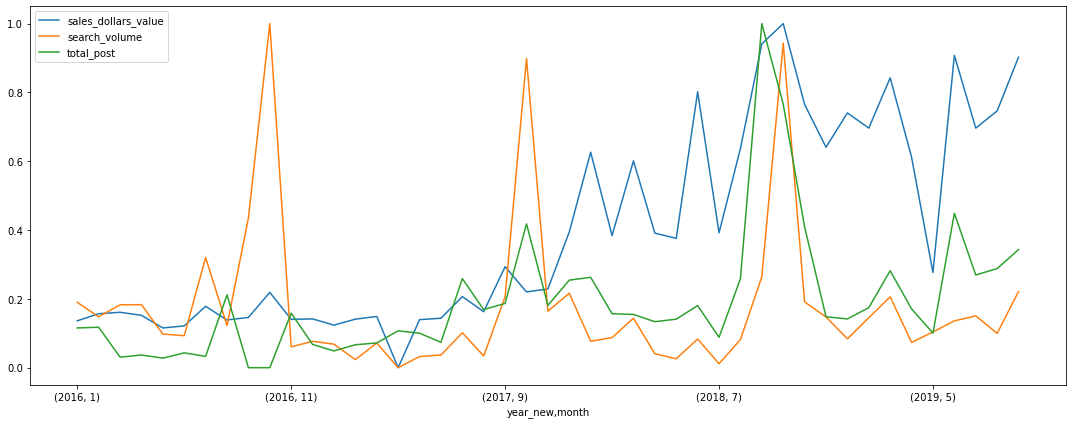

In [108]:
df.plot.line(figsize=(15,6))

In [110]:
final_hyp_df.claim_id.nunique()

28

FixedFormatter should only be used together with FixedLocator


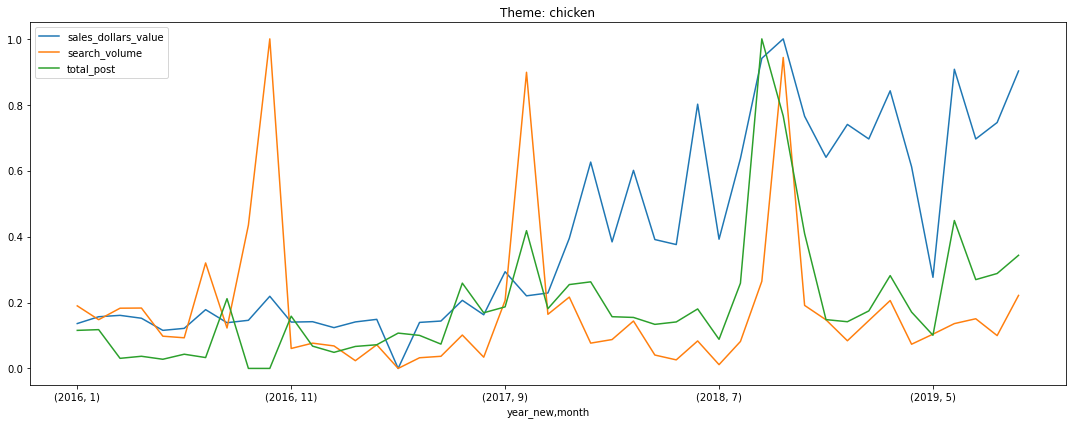

FixedFormatter should only be used together with FixedLocator


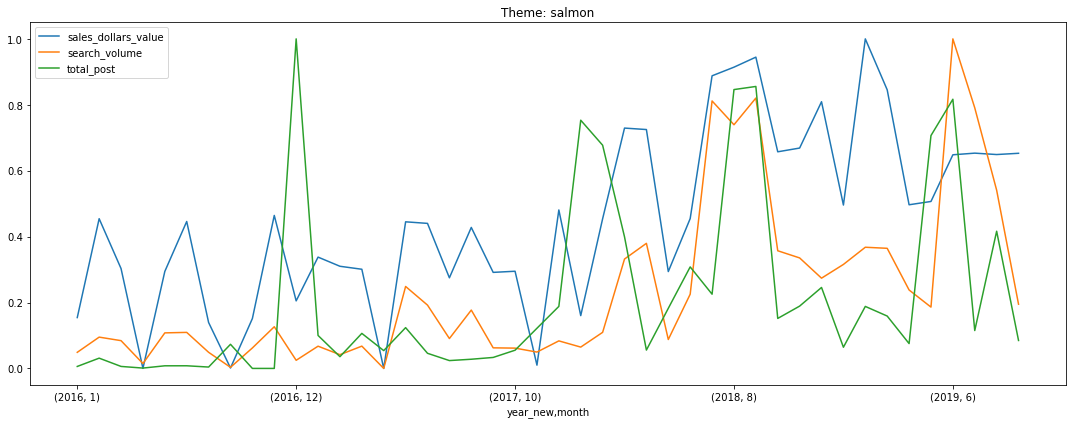

FixedFormatter should only be used together with FixedLocator


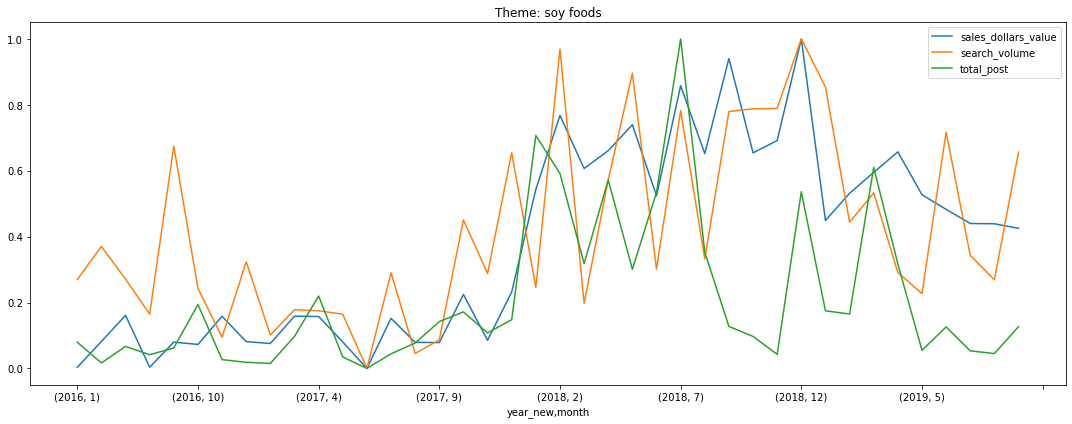

FixedFormatter should only be used together with FixedLocator


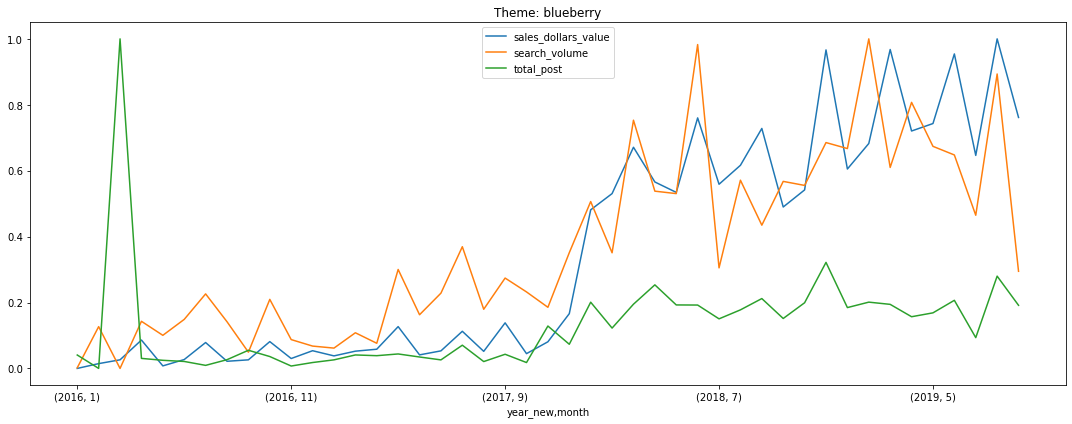

FixedFormatter should only be used together with FixedLocator


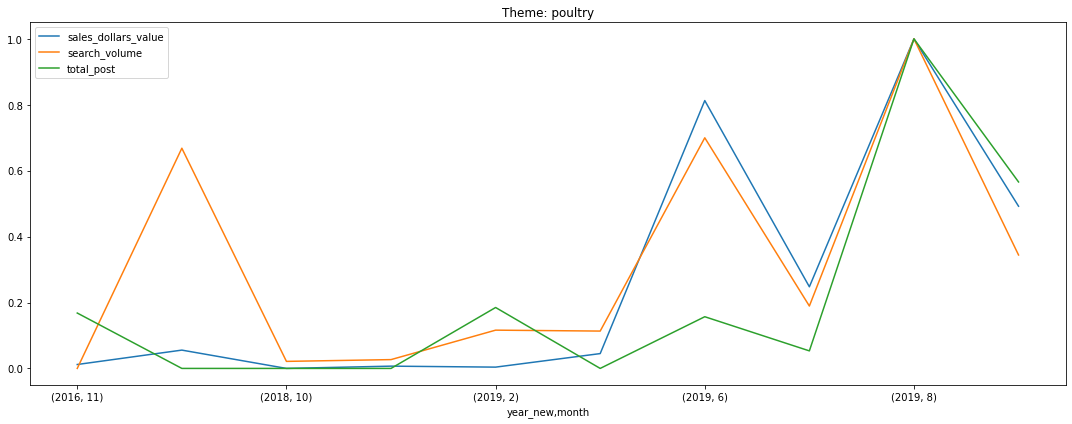

FixedFormatter should only be used together with FixedLocator


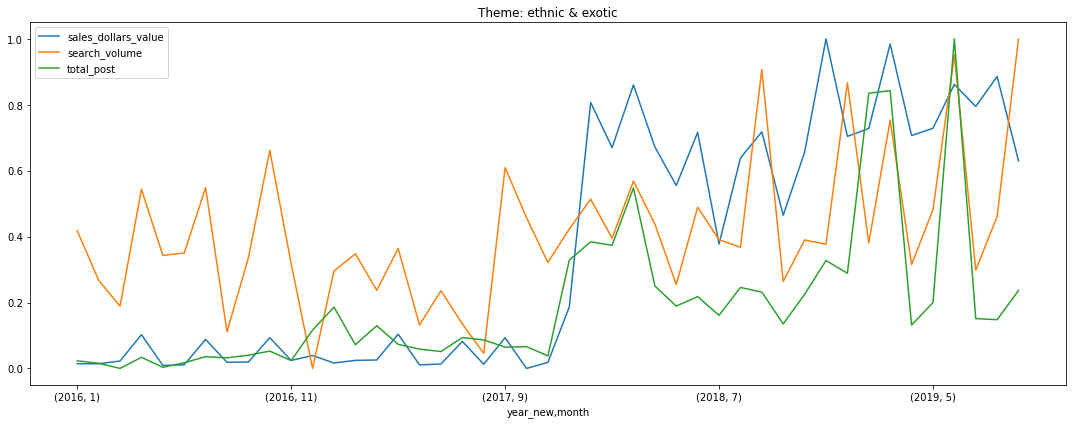

FixedFormatter should only be used together with FixedLocator


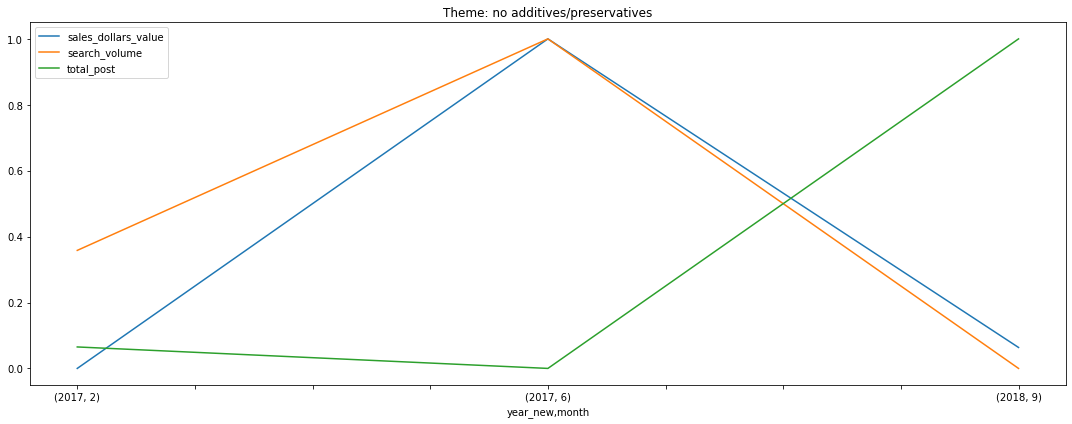

FixedFormatter should only be used together with FixedLocator


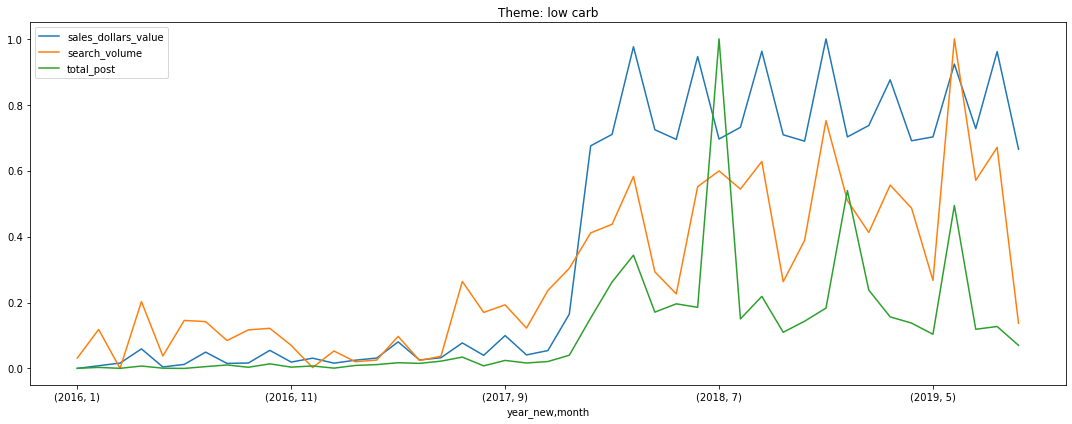

FixedFormatter should only be used together with FixedLocator


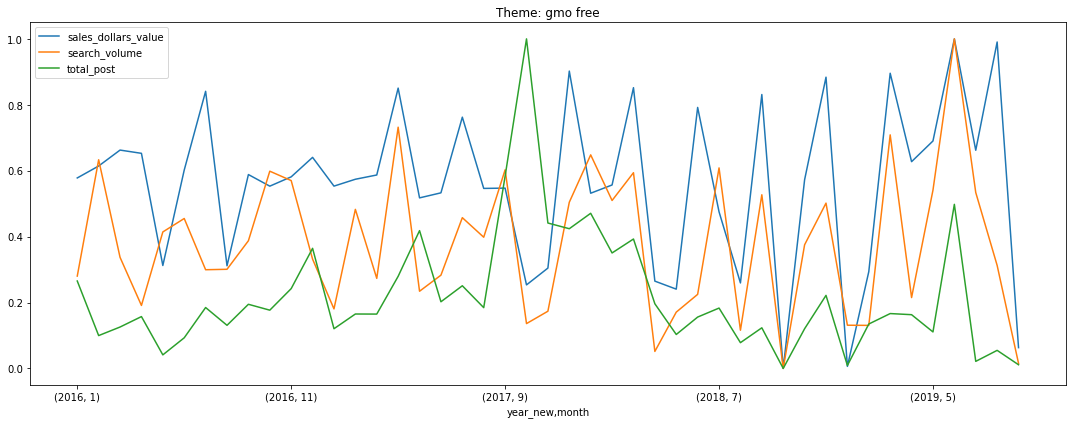

FixedFormatter should only be used together with FixedLocator


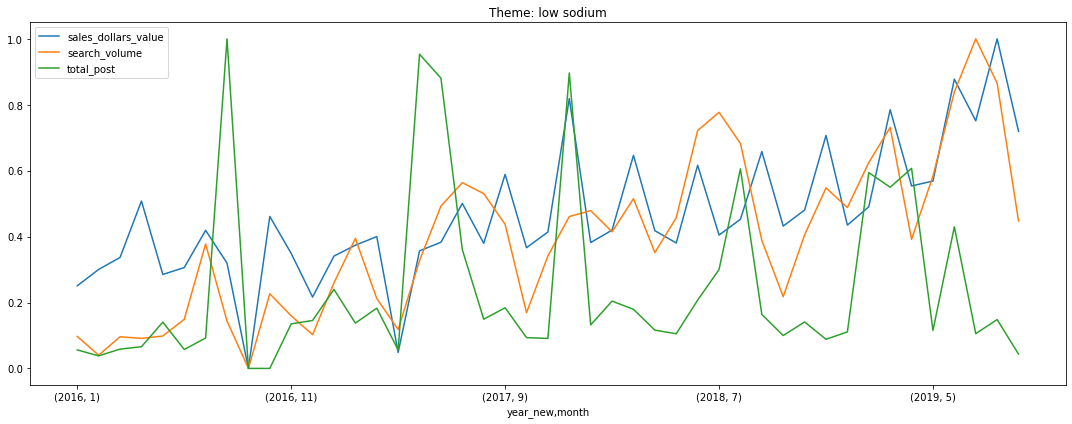

FixedFormatter should only be used together with FixedLocator


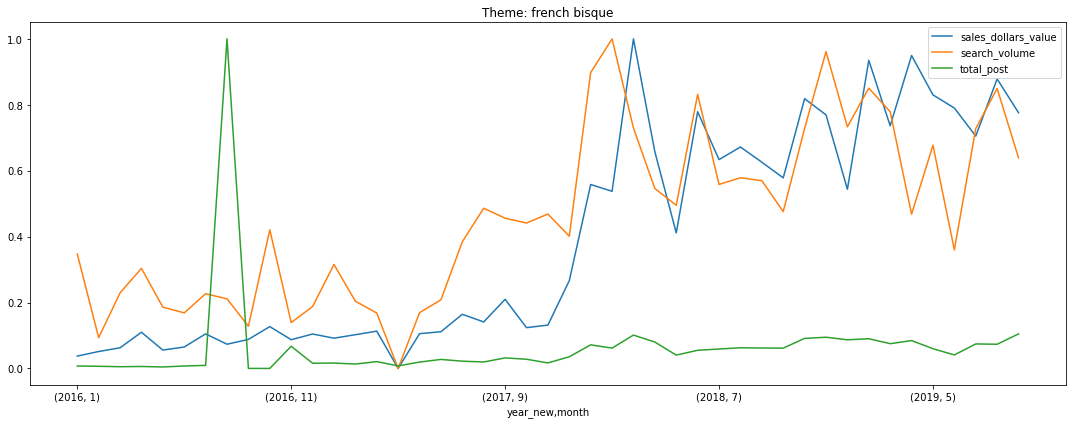

FixedFormatter should only be used together with FixedLocator


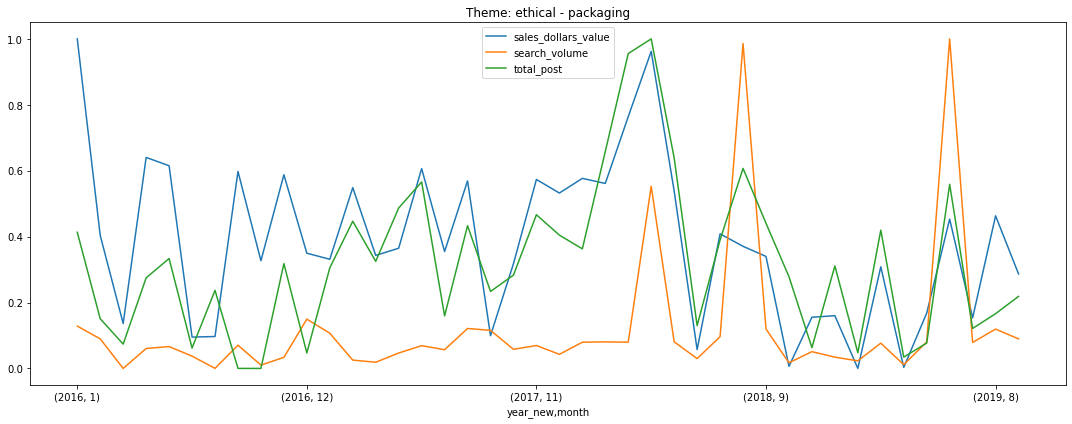

FixedFormatter should only be used together with FixedLocator


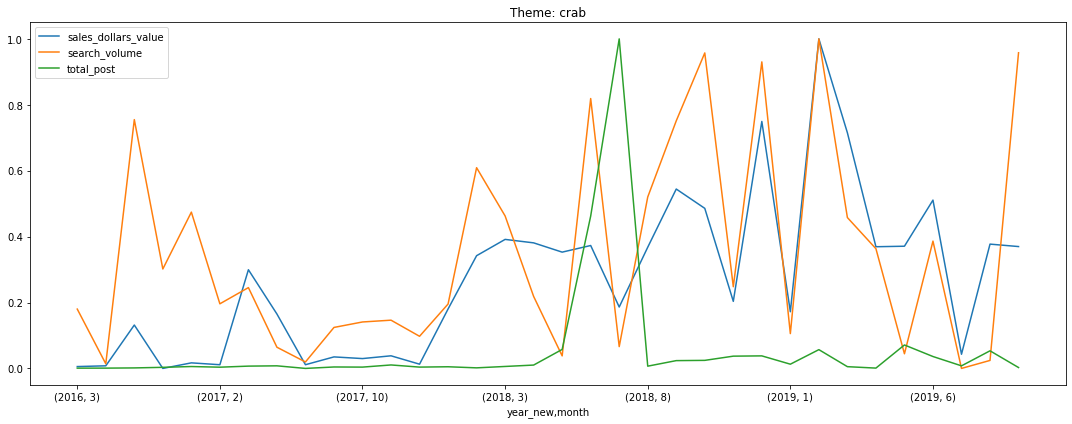

FixedFormatter should only be used together with FixedLocator


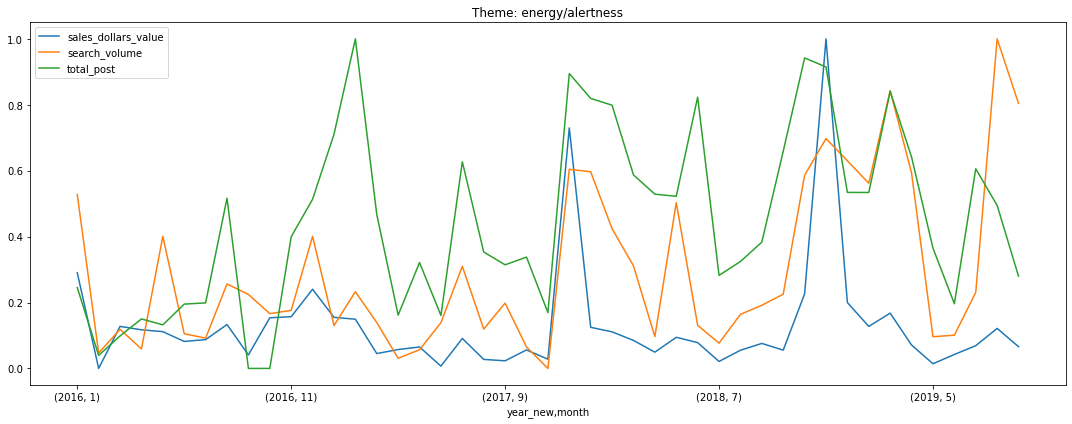

FixedFormatter should only be used together with FixedLocator


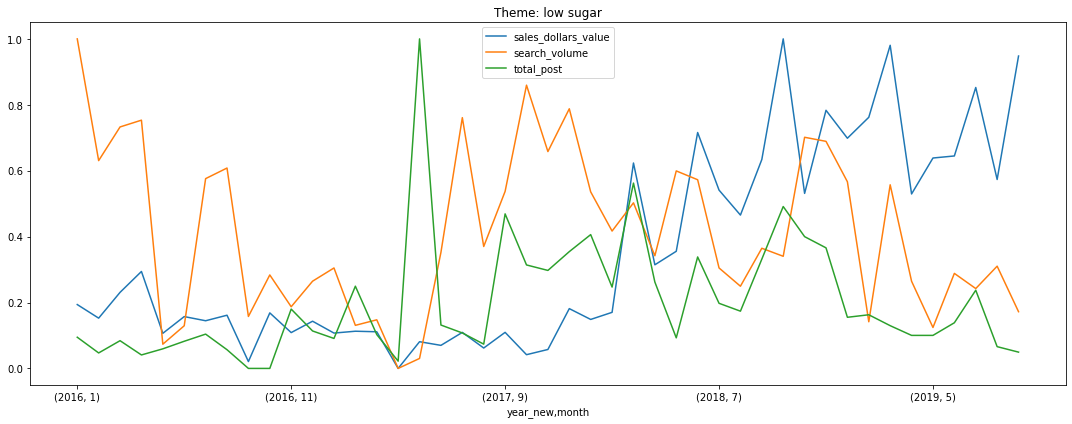

FixedFormatter should only be used together with FixedLocator


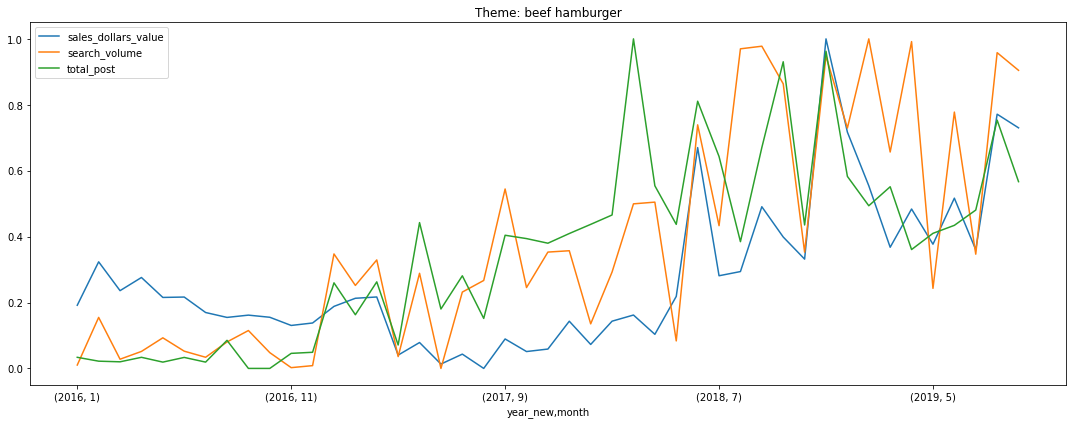

FixedFormatter should only be used together with FixedLocator


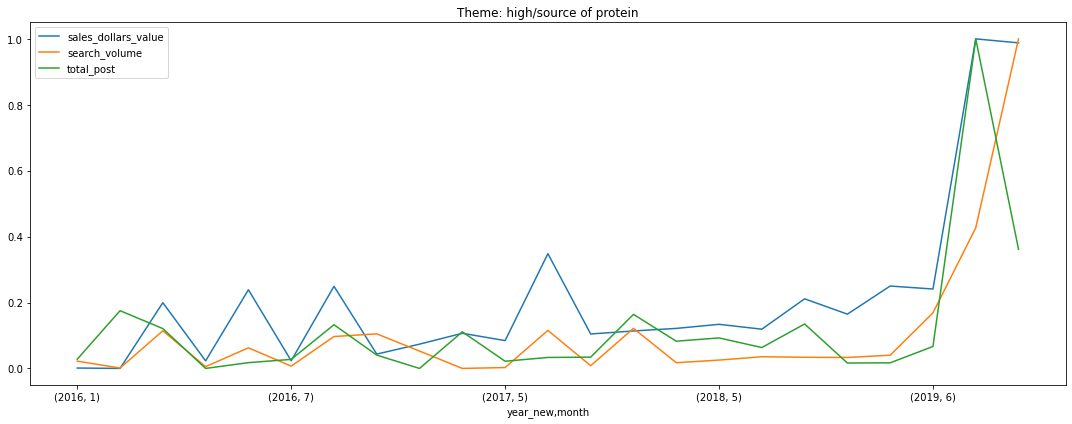

FixedFormatter should only be used together with FixedLocator


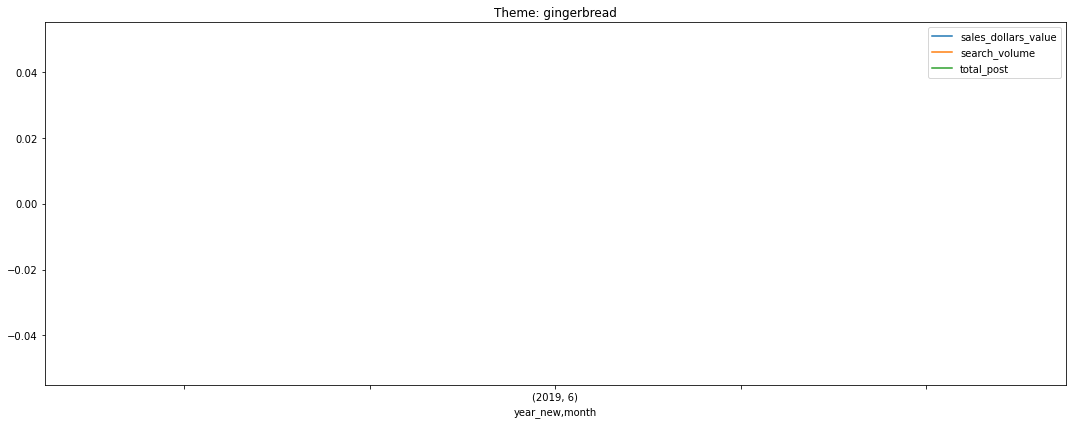

FixedFormatter should only be used together with FixedLocator


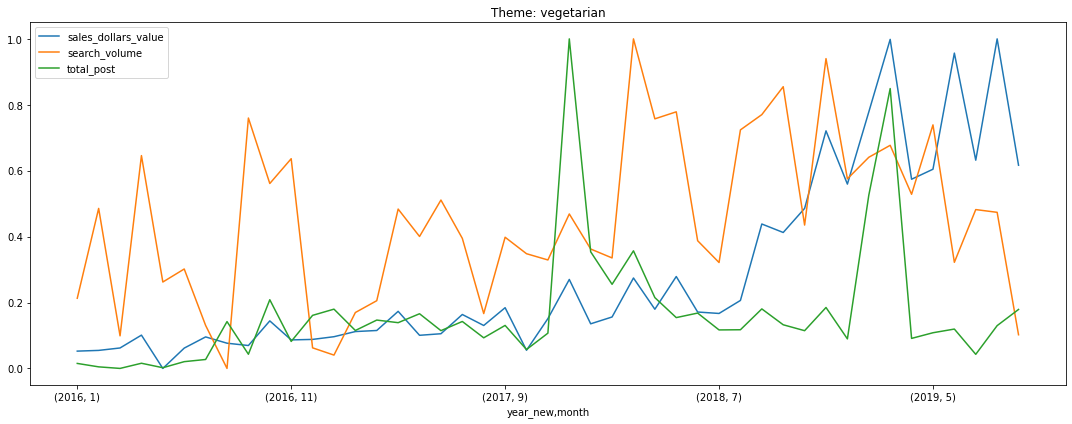

FixedFormatter should only be used together with FixedLocator


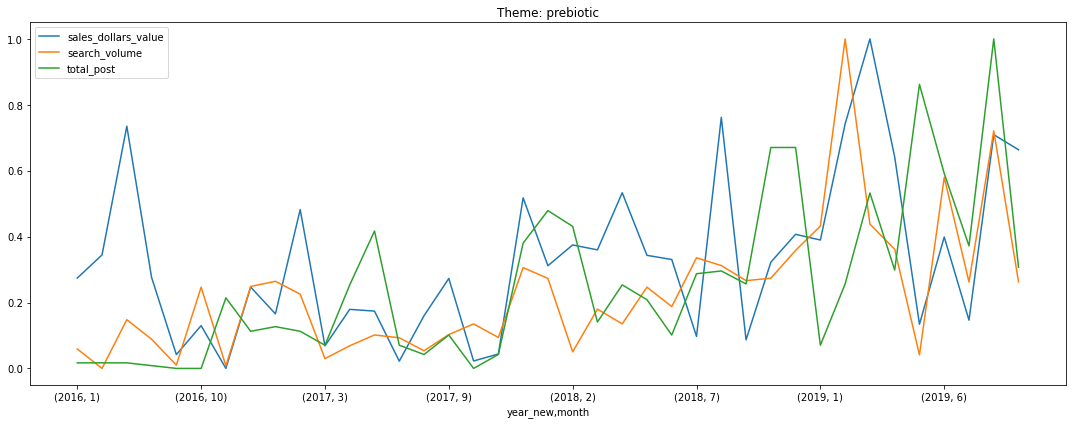

FixedFormatter should only be used together with FixedLocator


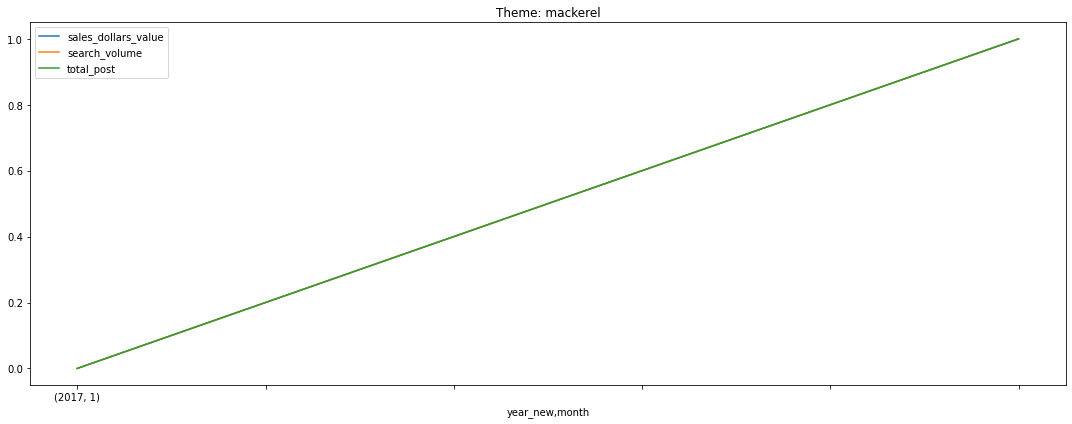

FixedFormatter should only be used together with FixedLocator


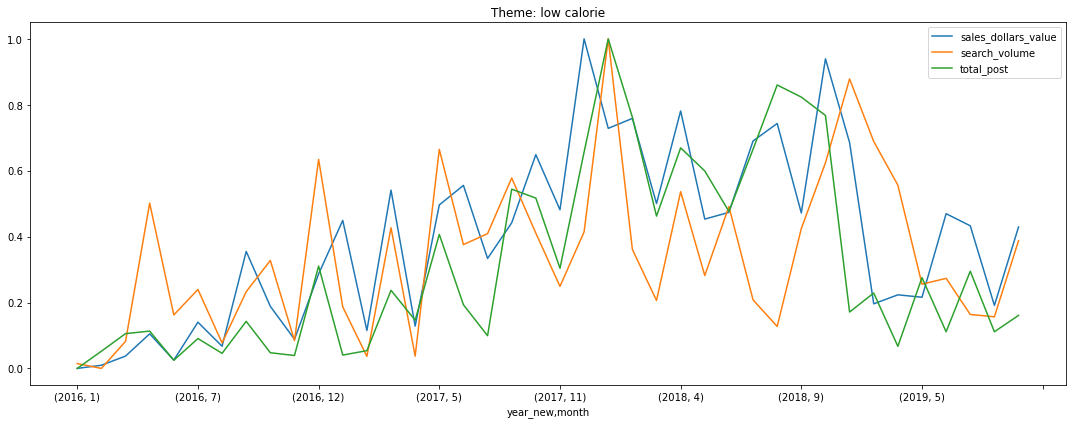

FixedFormatter should only be used together with FixedLocator


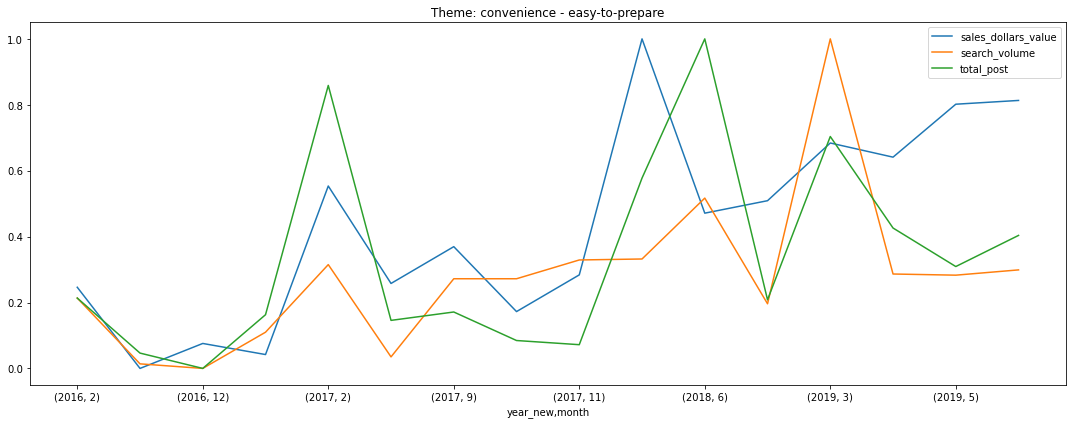

FixedFormatter should only be used together with FixedLocator


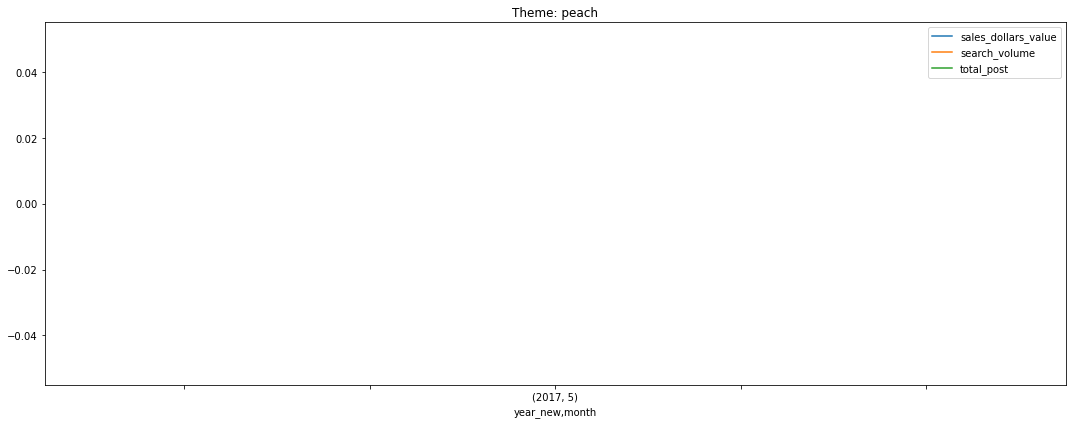

FixedFormatter should only be used together with FixedLocator


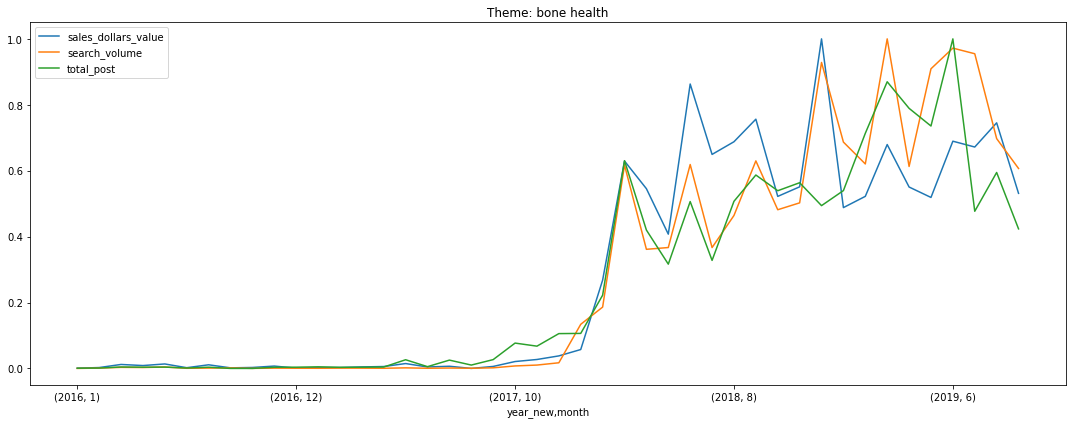

FixedFormatter should only be used together with FixedLocator


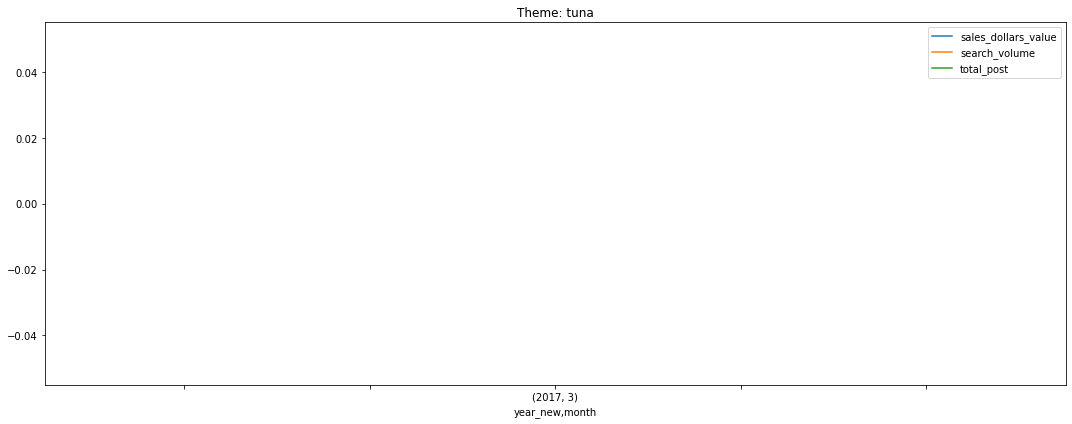

FixedFormatter should only be used together with FixedLocator


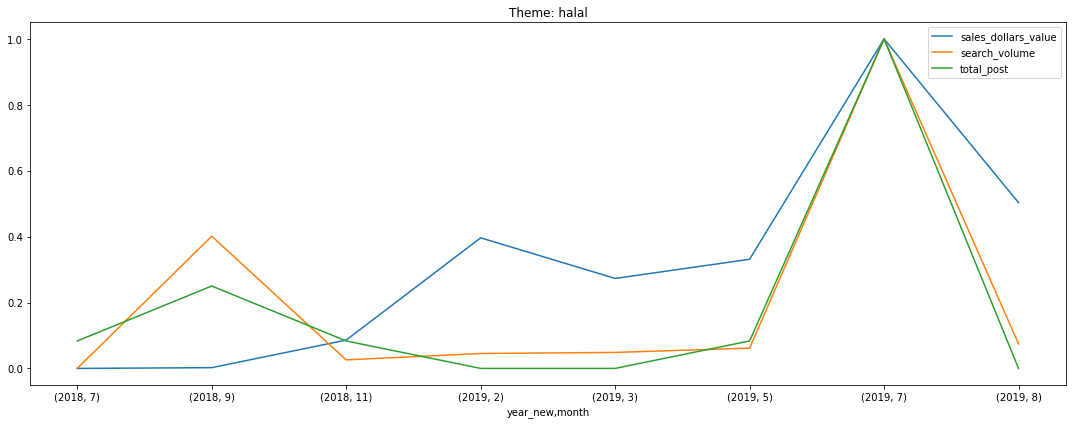

FixedFormatter should only be used together with FixedLocator


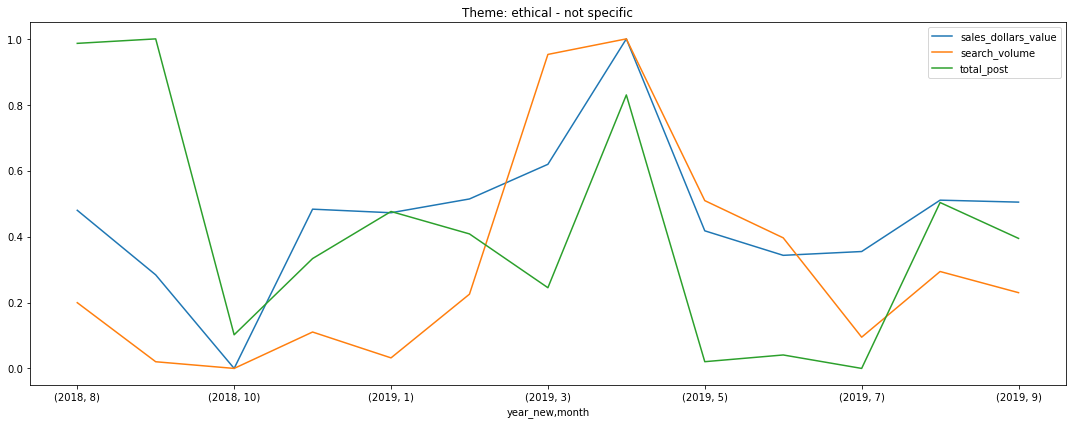

In [114]:
for i in final_hyp_df.claim_name.unique():
    latency_theme = final_hyp_df[final_hyp_df['claim_name'] == i]
    df = latency_theme.groupby(['year_new','month'])[['sales_dollars_value','search_volume','total_post']].sum()
    for j in df.columns:
        column = j
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    df.plot.line(figsize=(15,6))
    plt.title('Theme: {}'.format(i))
    plt.show()
    

In [ ]:
# ginger bread, tuna, mackerel, peach

In [124]:
d = final_hyp_df[final_hyp_df['claim_name'] == 'gingerbread']
d.product_id.nunique()

103

                sales_dollars_value  search_volume  total_post
year_new month                                                
2019     6                 679107.0           4223       14626


FixedFormatter should only be used together with FixedLocator


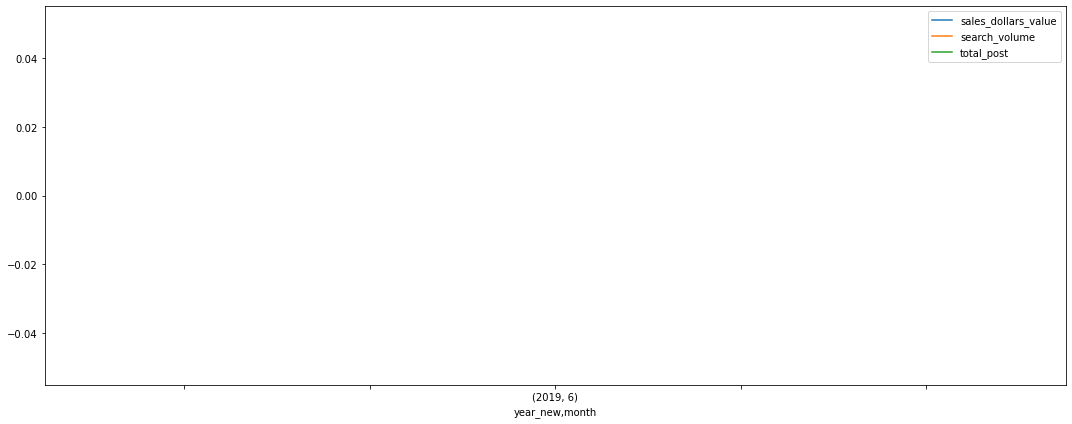

In [125]:
latency_theme = final_hyp_df[final_hyp_df['claim_name'] == 'gingerbread']
df = latency_theme.groupby(['year_new','month'])[['sales_dollars_value','search_volume','total_post']].sum()
print(df)
for j in df.columns:
    column = j
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
df.plot.line(figsize=(15,6))
# plt.title('Theme: {}'.format(i))
plt.show()

In [ ]:
google_df_clean.info()

## 2.3 Business intuition features

This section can go into production code if these features are used in final model

#### First Time Customer.
- A binary feature that tells if the customer is in business for the first time or not.

In [11]:
# first time customer
cust_details = sales_df.groupby(['customername']).agg({'ledger_date':'min'}).reset_index()
cust_details.columns = ['customername','ledger_date']
cust_details['first_time_customer'] = 1
sales_df = sales_df.merge(cust_details, on=['customername','ledger_date'], how='left')
sales_df['first_time_customer'].fillna(0, inplace=True)

#### Days Since Last Purchase of a customer
- Feature representing the number of days from the last purchase of a customer. 
- Quantifies the Gaps customers take b/w purchases

In [12]:
#### days since last purchase
sales_df.sort_values('ledger_date',inplace=True)
sales_df['days_since_last_purchase'] = (
    sales_df
       .groupby('customername')['ledger_date']
       .diff()
       .dt.days
       .fillna(0, downcast='infer'))

In [13]:
# create a sample dataframe with minimal processing

sales_df_processed = (
    sales_df
    
    # tweak to test pipeline quickly or profile performance
    #.sample(frac=1, replace=False)
    
    # any additional processing/cleaning
)

# Any verifications on the data
from ta_lib.eda.api import get_variable_summary
display_as_tabs([
    ("Summary", f"Length: {len(sales_df_processed)}, Columns: {len(sales_df_processed.columns)}"),
    ("Variable summary", get_variable_summary(sales_df_processed)),
    ("head", sales_df.head(5).T),
    ("tail", sales_df.tail(5).T),
])

tzname GB identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.


Tabs
    [0] Markdown(str, name='Summary')
    [1] DataFrame(name='Variable summary', value=                          ...)
    [2] DataFrame(name='head', value=              ...)
    [3] DataFrame(name='tail', value=                          ...)

In [14]:
save_dataset(context, sales_df_processed, 'cleaned/sales')

# 3. Generate Train, Validation and Test datasets



- We split the data into train, test (optionally, also a validation dataset)
- In this example, we are binning the target into 10 quantiles and then use a Stratified Shuffle to split the data.
- See sklearn documentation on the various available splitters
- https://scikit-learn.org/stable/modules/classes.html#splitter-classes
- This will go into production code (training only)

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
from ta_lib.core.api import custom_train_test_split  # helper function to customize splitting
from scripts import *

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=context.random_seed)
sales_df_train, sales_df_test = custom_train_test_split(sales_df_processed, splitter, by=binned_selling_price)

In [16]:
target_col = "unit_price"

train_X, train_y = (
    sales_df_train
    
    # split the dataset to train and test
    .get_features_targets(target_column_names=target_col)
)
save_dataset(context, train_X, 'train/sales/features')
save_dataset(context, train_y, 'train/sales/target')


test_X, test_y = (
    sales_df_test
    
    # split the dataset to train and test
    .get_features_targets(target_column_names=target_col)
)
save_dataset(context, test_X, 'test/sales/features')
save_dataset(context, test_y, 'test/sales/target')